# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART III: Modeling
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

In this section, we will work with the cleaned and merged bike station and weather data derived from Part I. We will explore the dataset to extract insights that will help develop a model to predict the  City of Toronto. 


## 0. Setup Notebook and Import Data

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import chardet
import string
import datetime
import geopandas as gpd
import folium
import matplotlib.ticker as ticker
from folium import Choropleth
from folium import Marker
import holidays
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

We will import the cleaned bike trip dataset that will be used for analysis. 

In [2]:
#Import cleaned bike trip data
df_trips_data=pd.read_csv('trips_data_modelling.csv')
df_trips_data.head()

,trip_id,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,...,stn_press_kpa,hmdx,wind_chill,weather,hour,bin,trip_dur_min,category,weather2,is_holiday
0,712441,NaN,274,7006,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,...,99.81,NaN,NaN,clear_day,0.050000,65 to 70,4.566667,Clear day,Clear,True
1,712442,NaN,538,7046,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,...,99.81,NaN,NaN,clear_day,0.050000,65 to 70,8.966667,Clear day,Clear,True
2,712443,NaN,992,7048,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,...,99.81,NaN,NaN,clear_day,0.083333,65 to 70,16.533333,Clear day,Clear,True
3,712444,NaN,1005,7177,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,...,99.81,NaN,NaN,clear_day,0.150000,65 to 70,16.750000,Clear day,Clear,True
4,712445,NaN,645,7203,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,...,99.81,NaN,NaN,clear_day,0.233333,65 to 70,10.750000,Clear day,Clear,True


We will keep the backup of the trip data saved in a different variable, in case we need to reset the applied manipulations. 

In [3]:
#backup of the dataframe
df_trips_data2=df_trips_data.copy()

#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
subscription_id,3199754,40.0
trip_duration,0,0.0
start_station_id,0,0.0
start_time,0,0.0
start_station_name,0,0.0
end_station_id,0,0.0
end_time,0,0.0
end_station_name,0,0.0
bike_id,3199754,40.0


In [4]:
df_trips_data = df_trips_data2.copy()

# 1. Understanding the Dataset With Respect to the Model

The intended outcome is the development of a model to determine the total hourly ride count. As such the station information is not required. The trips <code>'start_time'</code> will be used to group the trips per hour. The remaining station informaition can be removed from the dataframe using <code>.drop()</code>.

As the data was pulled from a .csv file the data types will have to be re-estabilshed. 


In [5]:
#drop features to be from station information
df_trips_data.drop(columns = ['trip_duration',
                               'end_time',
                               'time',
                               'subscription_id',
                               'start_station_id',
                               'start_station_name',
                               'end_station_id',
                               'end_station_name',
                               'bike_id',
                               'user_type',
                               'start_station_lat',
                               'start_station_lon',
                               'end_station_lat',
                               'end_station_lon',
                               'start_station_name_npl',
                               'end_station_name_npl',
                               'weather2',
                               'category',
                               'bin',
                               'trip_dur_min'],
                             inplace = True)
#add time zone information to datetimes
df_trips_data['start_time']=pd.to_datetime(df_trips_data['start_time'],utc=True)
df_trips_data['start_time']=df_trips_data['start_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['merge_time']=pd.to_datetime(df_trips_data['merge_time'],utc=True)
df_trips_data['merge_time']=df_trips_data['merge_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data.head()

,trip_id,start_time,merge_time,year,month,day,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather,hour,is_holiday
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:00:00-05:00,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day,0.050000,True
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:00:00-05:00,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day,0.050000,True
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:00:00-05:00,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day,0.083333,True
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:00:00-05:00,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day,0.150000,True
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:00:00-05:00,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day,0.233333,True


In [6]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_id,0,0.0
start_time,0,0.0
merge_time,0,0.0
year,0,0.0
month,0,0.0
day,0,0.0
temp_c,48475,0.6
dew_point_temp_c,59007,0.7
rel_hum_,57615,0.7
wind_dir_10s_deg,14177,0.2


In [7]:
#save point to be removed
df_trips_data2 = df_trips_data.copy()

In [8]:
#reset point
df_trips_data = df_trips_data2.copy()

### Feature Selection and Cleaning

Based on the fact the model aims to estimate the number of rides per hour and not the location or destination of the rides the information pertaining to the stations will be excluded from the dataset. <br> In addition both the >50% of the <code>'wind_chill'</code> and <code>'hmdx'</code> informaiton is missing, hence the features will be excluded. <br> All <code> 'null' </code> values will be removed from the remaining data set

### Ride Count Per Hour
In to predict the ride count per hour the rides will be grouped per hour. The features will be aggregated based on the mean for each hourly period.
<ul>
    <li> <b><u> Time Data: </u></b>
        <ul>
            <li> <code>'start_time'</code>: Will be used to group the trips per hour </li>
            <li> <code>'year'</code> </li>
            <li> <code>'day'</code> </li>
            <li> <code>'hour'</code>: This will be a descrete value rounded to the nearest hour</li>
        </ul>
    <li> <b><u> Weather Data: </u></b>
        <ul>
            <li> <code>'temperature'</code> </li>
            <li> <code>'dew_point_temp_c'</code> </li>
            <li> <code>'rel_hum'</code></li>
            <li> <code>'wind_dir_10s_deg'</code> </li>
            <li> <code>'wind_spd_km'</code></li>
            <li> <code>'visibility_km'</code> </li>
            <li> <code>'stn_press_kpa'</code></li>
            <li> <code>'waether'</code> The weather description cannot be aggegrated as it is a text. The Weather information is recorded per hour so the weather information will be merged based on the hourly timestamp</li>
        </ul>
<ul>
        
            

In [54]:
#drop two features with null value % greater than 50%
df_model_dataset = df_trips_data.drop(columns = ['wind_chill','hmdx'])

#'NAN' visibility features where set to np.inf set value to 16.1 km
df_model_dataset['visibility_km'].replace(np.inf, 16.6, inplace = True)

#drop records with null values
df_model_dataset.dropna(axis = 0)
#group trips based on hours and aggregate numberical features
df_model_dataset= df_trips_data.groupby(pd.Grouper(key="start_time",freq='H')).agg(trip_count=('trip_id',"count"))

#as a result of the 'Grouper' function there exist a potential that there are hours in the period where
# no trips were taken hence the creation of null values with in the data set
#Hence, reset all year, month, day and hour values. 
df_model_dataset['hour'] = df_model_dataset.index.hour
df_model_dataset['year'] = df_model_dataset.index.year
df_model_dataset['month'] = df_model_dataset.index.month
df_model_dataset['day'] = df_model_dataset.index.day

#Check if additional weather data can be pulled from original weather data frame so that hours with no trips can be included
# in the DF

df_weather_data = pd.read_csv('cleaned_weather_data_set.csv')
df_weather_data['datetime']=pd.to_datetime(df_weather_data['datetime'],utc=True)
df_weather_data['datetime']=df_weather_data['datetime'].dt.tz_convert(tz='US/Eastern')

df_model_dataset = pd.merge(df_model_dataset, df_weather_data[['datetime',
                                                            'temp_c',
                                                            'dew_point_temp_c',
                                                            'rel_hum_',
                                                            'wind_dir_10s_deg',
                                                            'wind_spd_kmh',
                                                            'visibility_km',
                                                            'stn_press_kpa',
                                                            'weather']],left_index = True, right_on = 'datetime', how = 'left')

#remove hours where there is missing weather data
df_model_dataset = df_model_dataset[~(df_model_dataset['temp_c'].isnull() | 
                                      df_model_dataset['dew_point_temp_c'].isnull()| 
                                      df_model_dataset['rel_hum_'].isnull()|
                                      df_model_dataset['wind_dir_10s_deg'].isnull()|
                                      df_model_dataset['wind_spd_kmh'].isnull()|
                                     df_model_dataset['stn_press_kpa'].isnull())]

#add holiday Field
canadian_holidays = holidays.Canada(years = [2017, 2018, 2019, 2020])
#add a is_holiday feature to the df_trips_data based on the presence of the date in the list
df_model_dataset['is_holiday'] = [x in canadian_holidays for x in df_model_dataset['datetime']]
#change True/False to 1 /0
df_model_dataset['is_holiday'] =df_model_dataset['is_holiday'].astype(int)
#add day of the week field
df_model_dataset['day_of_week'] =df_model_dataset['datetime'].dt.weekday

#add freeride wednesday
#free ride dictionary year:month
freeride = {2017:7,2018:6,2019:8,2020:9}
df_model_dataset['promo'] = np.zeros(df_model_dataset.shape[0])
for yr in list(freeride.keys()):
    mask = (df_model_dataset['year'] == yr) & (df_model_dataset['month'] == freeride[yr]) & (df_model_dataset['day_of_week'] == 2)
    df_model_dataset.loc[mask,'promo'] = 1

#replace np.inf with 16.1 in the visibility feature
df_model_dataset['visibility_km'].replace(np.inf,16.1, inplace=True)

#display data
print (df_model_dataset.shape[0])
df_model_dataset.head()

33411


,trip_count,hour,year,month,day,datetime,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,weather,is_holiday,day_of_week,promo
0,18,0,2017,1,1,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,clear_day,1,6,0.0
1,13,1,2017,1,1,2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,clear_day,1,6,0.0
2,15,2,2017,1,1,2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,clear_day,1,6,0.0
3,10,3,2017,1,1,2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,clear_day,1,6,0.0
4,5,4,2017,1,1,2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,clear_day,1,6,0.0


In [11]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_model_dataset.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_model_dataset.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
trip_count,0,0.0
hour,0,0.0
year,0,0.0
month,0,0.0
day,0,0.0
datetime,0,0.0
temp_c,0,0.0
dew_point_temp_c,0,0.0
rel_hum_,0,0.0
wind_dir_10s_deg,0,0.0


# Exploratory Data Analysis

Break Down of Rides Per Hour
Q1= 33.0
Q2= 127.0
Q3= 329.0
Maxium= 2433
Average=238
Minimum= 0


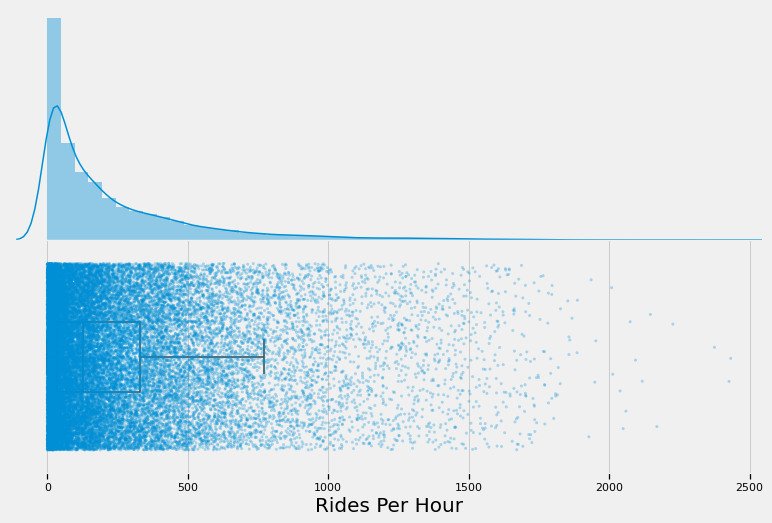

In [49]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    df_model_dataset['trip_count'].values, 
    ax=axs[0]
)
sns.stripplot(
    df_model_dataset['trip_count'].values, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df_model_dataset['trip_count'].values,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df_model_dataset['trip_count']) * 0.05
xmin = np.min(df_model_dataset['trip_count']) - spacer
xmax = np.max(df_model_dataset['trip_count']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('Rides Per Hour', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')
#sns.boxplot(data = df_model_dataset, y = 'trip_count')
#Estimate quartile values for Visibility column
Q1=np.percentile(df_model_dataset['trip_count'], 25)  # Q1
Q2=np.percentile(df_model_dataset['trip_count'], 50)  # median
Q3=np.percentile(df_model_dataset['trip_count'], 75)  # Q3
Max = df_model_dataset['trip_count'].max()
Mean = df_model_dataset['trip_count'].mean()
Min = df_model_dataset['trip_count'].min()

print('Break Down of Rides Per Hour')
print("Q1=",Q1)
print("Q2=",Q2)
print("Q3=",Q3)
print("Maxium=",Max)
print("Average={:.0f}".format(Mean))
print("Minimum=",Min)

# 1. Split Data Set into Train, Validation and Test

Split according the the following:<br>
> 70% Training <br>
> 20% Validation <br>
> 10% Test <br>

In [62]:
from sklearn.model_selection import train_test_split

# Write your code here.
train, val = train_test_split(df_model_dataset, train_size = 0.7)
val, test = train_test_split(val, test_size = 0.333334)

train.reset_index(inplace = True)
val.reset_index(inplace = True)
test.reset_index(inplace = True)

# Print results
print('Train {:.1f}%'.format(train.shape[0] / df_model_dataset.shape[0] * 100))
print('Val {:.1f}%'.format(val.shape[0] / df_model_dataset.shape[0] * 100))
print('Test {:.1f}%'.format(test.shape[0] / df_model_dataset.shape[0] * 100))
train.head()

Train 70.0%
Val 20.0%
Test 10.0%


,index,trip_count,hour,year,month,day,datetime,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,weather,is_holiday,day_of_week,promo
0,11663,38,0,2017,5,6,2017-05-06 00:00:00-04:00,7.6,5.9,89.0,33.0,22.0,16.1,98.79,clear_day,0,5,0.0
1,4324,1,4,2019,2,1,2019-02-01 04:00:00-05:00,-16.8,-21.4,68.0,29.0,18.0,16.1,101.90,clear_day,0,4,0.0
2,1037,1,5,2018,1,13,2018-01-13 05:00:00-05:00,-12.5,-19.0,59.0,33.0,28.0,16.1,101.02,clear_day,0,5,0.0
3,10685,21,6,2019,4,25,2019-04-25 06:00:00-04:00,4.3,2.7,90.0,0.0,4.0,16.1,100.44,clear_day,0,3,0.0
4,10697,900,18,2019,4,25,2019-04-25 18:00:00-04:00,7.4,3.8,78.0,8.0,21.0,16.1,100.13,clear_day,0,3,0.0


## Simplistic Prediction based on average and mode

In [63]:
mean_trip_count = train['trip_count'].mean()
mode_trip_count = train['trip_count'].mode()[0]

mean_error = np.sqrt(np.sum((val['trip_count'] - mean_trip_count)**2)/len(val['trip_count']))
mode_error = np.sqrt(np.sum((val['trip_count'] - mode_trip_count)**2)/len(val['trip_count']))

print('Error based on a prediction using the mean:{:.2f}, which is a value of {:.2f}'.format(mean_error,mean_trip_count))
print('Error based on a prediction using the mode:{:.2f}, which is a value of {:.2f}'.format(mode_error, mode_trip_count))

Error based on a prediction using the mean:302.63, which is a value of 237.12
Error based on a prediction using the mode:383.51, which is a value of 4.00


# Generation of simple model
### Features
<ul> 
    <li> <b> Hour: </b> There is a cyclic relationship noted between the hour of the day and the trip count </li>
    <li> <b> Year: </b> The number of trips increased per year hence year to be considered to account for yearly increas </li>
    <li> <b> Month: </b> Will <b> not</b> considered due to the relationship between the month and temperature </li>
    <li> <b> Temperature: </b> Included </li>
    <li> <b> Wind Speed: </b> included </li>
    <li> <b> Day of the week: </b> Hourly difference noted between weekdays and weekends </li>
    <li> <b> is holiday: </b> Hourly difference noted between weekdays and holidays </li>
<ul>

In [64]:
def simple_features (data):
    simple_feature_list = ['hour','year','temp_c','wind_spd_kmh','day_of_week','is_holiday']
    x = data[simple_feature_list]
    y = data['trip_count']
    return x, y


In [65]:
x_train, y_train = simple_features(train)
x_val, y_val = simple_features(val)

In [66]:
linear_model = LinearRegression(fit_intercept = True)
linear_model.fit(x_train,y_train)
simple_predicted = linear_model.predict(x_val)
simple_error = mean_squared_error(simple_predicted, y_val, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(simple_error))

The mean absolute error for the simple Linear Regression is: 231.20


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

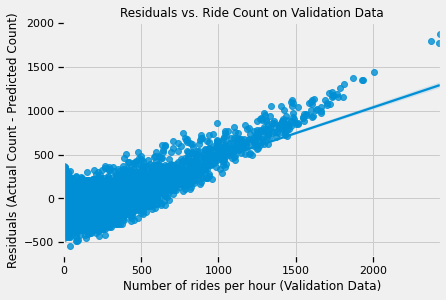

In [67]:
residuals = y_val - simple_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

# Feature Engineering for Linear Regression

Consider the following: 
<ul> 
    <li> Addition of weather Binary Clear Day vs Precipitation</li>
    <li> Binary Classification of the Day week day vs Holiday / weekend </li>
    <li> Polynomial Features: The relationship between ride count and both the hour and the month is non linear</li>
</ul>


In [68]:

def engineered_features(data):
    df = data.copy()
        
    #differentiate between clear_days and other days
    mask = data['weather'] =='clear_day'
    df.loc[~mask,'weather'] = 'precipitation'
    df = pd.get_dummies(df,columns = ['weather'], prefix = 'w')
    #bin humidty ranges
    df['hum_bin'] =  pd.cut(df['rel_hum_'], bins = range(0,101,10), labels = range(0,10))
    df['temp_bin'] =  pd.cut(df['temp_c'], bins = range(-25,40,5), labels = range(0,12))
   
    #consider polynimial features for hour and month
    transformer = PolynomialFeatures(degree=3)
    df = pd.concat([df,pd.DataFrame(columns =['c_h', 'x1_h', 'x2_h', 'x3_h'], 
                                    data = transformer.fit_transform(df[['hour']]) )], 
                   axis = 1)
    
    transformer = PolynomialFeatures(degree=2)
    df = pd.concat([df,pd.DataFrame(columns =['c_m', 'x1_m', 'x2_m'], 
                                    data = transformer.fit_transform(df[['month']]) )], 
                   axis = 1)
        
    y = df['trip_count']
    
    x = df[['year','temp_c','wind_spd_kmh','w_clear_day', 'w_precipitation','hum_bin',
            'c_h', 'x1_h', 'x2_h','x3_h', 'c_m', 'x1_m', 'x2_m', 'is_holiday', 'day_of_week']] #,'week_v_weekend', 'month'
    
    return x, y

x_train, y_train = engineered_features(train)
x_val, y_val = engineered_features(val)
x_train.head()
    

,year,temp_c,wind_spd_kmh,w_clear_day,w_precipitation,hum_bin,c_h,x1_h,x2_h,x3_h,c_m,x1_m,x2_m,is_holiday,day_of_week
0,2017,7.6,22.0,1,0,8,1.0,0.0,0.0,0.0,1.0,5.0,25.0,0,5
1,2019,-16.8,18.0,1,0,6,1.0,4.0,16.0,64.0,1.0,2.0,4.0,0,4
2,2018,-12.5,28.0,1,0,5,1.0,5.0,25.0,125.0,1.0,1.0,1.0,0,5
3,2019,4.3,4.0,1,0,8,1.0,6.0,36.0,216.0,1.0,4.0,16.0,0,3
4,2019,7.4,21.0,1,0,7,1.0,18.0,324.0,5832.0,1.0,4.0,16.0,0,3


In [69]:
linear_model.fit(x_train,y_train)
fe_predicted = linear_model.predict(x_val)
fe_error = mean_squared_error(fe_predicted, y_val, squared = False)
print('The mean absolute error for the Engineered Feature Linear Regression is: {:.2f}'. format(fe_error))

The mean absolute error for the Engineered Feature Linear Regression is: 207.76


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

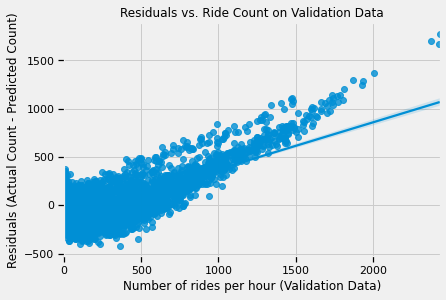

In [70]:
residuals = y_val - fe_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

## Addition of visibility to the feature set


In [71]:
def vis_engineered_features(data):
    df = data.copy()
        
    #differentiate between clear_days and other days
    mask = data['weather'] =='clear_day'
    df.loc[~mask,'weather'] = 'precipitation'
    df = pd.get_dummies(df,columns = ['weather'], prefix = 'w')
    #bin humidty ranges
    df['hum_bin'] =  pd.cut(df['rel_hum_'], bins = range(0,101,10), labels = range(0,10))
    df['temp_bin'] =  pd.cut(df['temp_c'], bins = range(-25,40,5), labels = range(0,12))
   
    #consider polynimial features for hour and month
    transformer = PolynomialFeatures(degree=3)
    df = pd.concat([df,pd.DataFrame(columns =['c_h', 'x1_h', 'x2_h', 'x3_h'], 
                                    data = transformer.fit_transform(df[['hour']]) )], 
                   axis = 1)
    transformer = PolynomialFeatures(degree=2)
    df = pd.concat([df,pd.DataFrame(columns =['c_m', 'x1_m', 'x2_m'], 
                                    data = transformer.fit_transform(df[['month']]) )], 
                   axis = 1)
    
    y = df['trip_count']
    
    x = df[['year','temp_c','wind_spd_kmh','w_clear_day', 'w_precipitation','hum_bin',
            'c_h', 'x1_h', 'x2_h','x3_h', 'c_m', 'x1_m', 'x2_m', 'is_holiday', 'day_of_week', 'visibility_km']] #,'week_v_weekend', 'month'
    
    return x, y

x_train, y_train = vis_engineered_features(train)
x_val, y_val = vis_engineered_features(val)
x_train.head()

,year,temp_c,wind_spd_kmh,w_clear_day,w_precipitation,hum_bin,c_h,x1_h,x2_h,x3_h,c_m,x1_m,x2_m,is_holiday,day_of_week,visibility_km
0,2017,7.6,22.0,1,0,8,1.0,0.0,0.0,0.0,1.0,5.0,25.0,0,5,16.1
1,2019,-16.8,18.0,1,0,6,1.0,4.0,16.0,64.0,1.0,2.0,4.0,0,4,16.1
2,2018,-12.5,28.0,1,0,5,1.0,5.0,25.0,125.0,1.0,1.0,1.0,0,5,16.1
3,2019,4.3,4.0,1,0,8,1.0,6.0,36.0,216.0,1.0,4.0,16.0,0,3,16.1
4,2019,7.4,21.0,1,0,7,1.0,18.0,324.0,5832.0,1.0,4.0,16.0,0,3,16.1


The mean absolute error for the simple Linear Regression is: 207.74


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

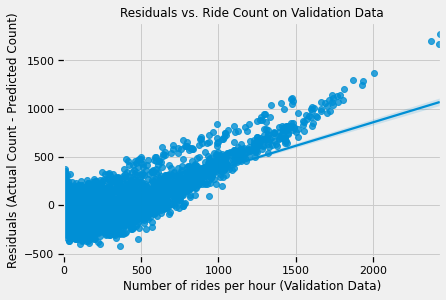

In [72]:
linear_model.fit(x_train,y_train)
vfe_predicted = linear_model.predict(x_val)
vfe_error = mean_squared_error(vfe_predicted, y_val, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(vfe_error))
residuals = y_val - vfe_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

# Cross validation of model using kFold split

In [73]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    ten_fold = KFold(n_splits=10)
    rmse_values = []
    
    # Iterature thought cv-folds
    for train_index, val_index in ten_fold.split(X):
        # Write your code here.
        X_CV_train, X_CV_val = X.iloc[train_index,:], X.iloc[val_index,:]
        y_CV_train, y_CV_val = y.iloc[train_index], y.iloc[val_index]      
        # Fit model
        model.fit(X_CV_train,y_CV_train)
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y_CV_val,model.predict(X_CV_val),squared = False))
        
    return rmse_values, model

Cross-validation RMSE scores: [208.01139513082234, 199.68715479794702, 192.32138709336317, 201.47838961846753, 204.5941085276127, 204.2205314305173, 200.21649094012142, 212.46504667778743, 202.58753148409505, 211.07616696728545]
Cross-validation RMSE scores mean: 203.67
Cross-validation RMSE scores std: 5.61
The mean absolute error for the simple Linear Regression is: 207.78


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

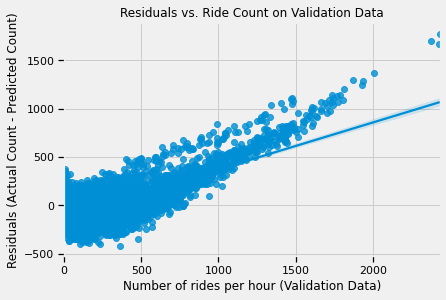

In [74]:
cv_scores, lt_model = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_train, y=y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {:.2f}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {:.2f}'.format(np.std(cv_scores)))
ten_fold_avg_rmse = np.mean(cv_scores)

y_predict = lt_model.predict(x_val)
kfold_error = mean_squared_error(y_val, y_predict, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(kfold_error))
residuals = y_val -y_predict
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

# Correlation between features

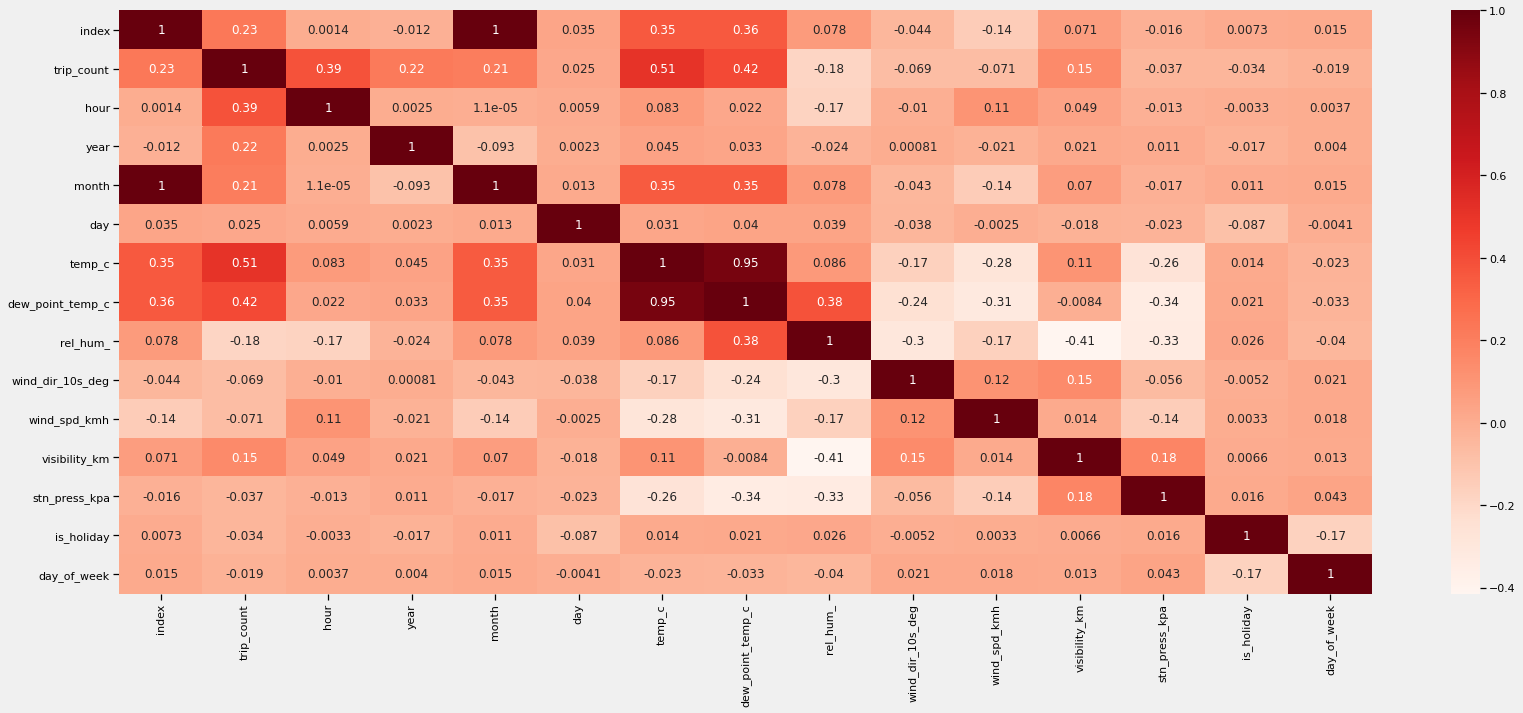

In [26]:
corr = train.corr()
fig, ax = plt.subplots(1,1,figsize = (25,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds, ax = ax)
plt.show()

In [27]:
#Correlation with output variable
cor_target = abs(corr["trip_count"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

index               0.228528
trip_count          1.000000
hour                0.385344
year                0.224005
month               0.208958
temp_c              0.509188
dew_point_temp_c    0.416078
Name: trip_count, dtype: float64

# Consider feature with correlation of >0.2

In [28]:
def corr_features(data):
    x = data[['hour','temp_c','dew_point_temp_c']]
    y = data['trip_count']
    return x,y

In [29]:
x_train, y_train = corr_features(train)
x_val, y_val = corr_features(val)

cv_scores, lt_model = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_train, y=y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {:.2f}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {:.2f}'.format(np.std(cv_scores)))
corr_avg_rmse = np.mean(cv_scores)

Cross-validation RMSE scores: [223.82313096070416, 233.2900701518874, 229.51441232792007, 240.03682996445247, 223.37199079725914, 228.69142531597745, 233.82170563865893, 233.39093222549428, 236.7471750048922, 229.24814003519563]
Cross-validation RMSE scores mean: 231.19
Cross-validation RMSE scores std: 5.04


## Remove Outlier for generation of the model

In [37]:
def remove_outliers (data):
    df = data.copy()
    df = df[(df['trip_count'] > Q1) & (df['trip_count'] < Q3)]
    df.reset_index(drop = True, inplace = True)
    return df


In [39]:
x_no_train, y_no_train = vis_engineered_features(remove_outliers(train))

cv_scores, lt_model = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_no_train, y=y_no_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {:.2f}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {:.2f}'.format(np.std(cv_scores)))
no_outliers_avg_rmse = np.mean(cv_scores)

Cross-validation RMSE scores: [64.55756978362102, 64.96188202094841, 63.93559579003775, 64.10439409191741, 65.07241440087506, 65.84509957761712, 63.57272414719994, 64.93001748553847, 65.12898921264376, 64.43444297371299]
Cross-validation RMSE scores mean: 64.65
Cross-validation RMSE scores std: 0.64


# Final Model Considerations
Considering the annual cyclic nature of the data set consider splitting the data set according to year.
<ul>
    <li> <b>Training Data:</b></li>
    <ul>
        <li> 2018 </li>
        <li> 2019 </li>
    </ul>
    <li> <b>Validation Data:</b></li>
    <ul>
        <li> 2017 </li>
    </ul>
    <li> <b>Test Data:</b></li>
    <ul>
        <li> 2020 </li>
    </ul>
</ul>

The outliers will also be removed from the data set
        

Cross-validation RMSE scores: [67.8986909542482, 58.96522529379199, 68.44073210146165, 69.2431996787235, 55.563618838314, 68.3896551891034, 61.92370969390976, 69.44825717648256, 76.15241980235812, 65.0603641282499]
Cross-validation RMSE scores mean: 66.11
Cross-validation RMSE scores std: 5.63
The mean absolute error for the simple Linear Regression is: 131.16


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

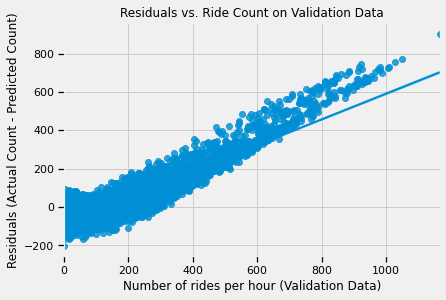

In [56]:
train = df_model_dataset[(df_model_dataset['year'] ==2018) | (df_model_dataset['year'] ==2019)]

train = remove_outliers(train)

x_no_train, y_no_train = vis_engineered_features(remove_outliers(train))


val = df_model_dataset[(df_model_dataset['year'] ==2017)]
val.reset_index(drop=True, inplace = True)
x_val, y_val = vis_engineered_features(val)



cv_scores, lt_model = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_no_train, y=y_no_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {:.2f}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {:.2f}'.format(np.std(cv_scores)))
annual_avg_rmse = np.mean(cv_scores)

#test on validation data set
y_predict = lt_model.predict(x_val)

annual_val_error = mean_squared_error(y_val, y_predict, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(annual_val_error))
residuals = y_val -y_predict
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

#### Consider including "freeride" Wednesday into the feature generation

In [57]:
def frw_engineered_features(data):
    df = data.copy()
    
     
    #differentiate between clear_days and other days
    mask = data['weather'] =='clear_day'
    df.loc[~mask,'weather'] = 'precipitation'
    df = pd.get_dummies(df,columns = ['weather'], prefix = 'w')
    #bin humidty ranges
    df['hum_bin'] =  pd.cut(df['rel_hum_'], bins = range(0,101,10), labels = range(0,10))
    df['temp_bin'] =  pd.cut(df['temp_c'], bins = range(-25,40,5), labels = range(0,12))
   
    #consider polynimial features for hour and month
    transformer = PolynomialFeatures(degree=3)
    df = pd.concat([df,pd.DataFrame(columns =['c_h', 'x1_h', 'x2_h', 'x3_h'], 
                                    data = transformer.fit_transform(df[['hour']]) )], 
                   axis = 1)
    transformer = PolynomialFeatures(degree=2)
    df = pd.concat([df,pd.DataFrame(columns =['c_m', 'x1_m', 'x2_m'], 
                                    data = transformer.fit_transform(df[['month']]) )], 
                   axis = 1)
    
    y = df['trip_count']
    
    x = df[['year','temp_c','wind_spd_kmh','w_clear_day', 'w_precipitation','hum_bin',
            'c_h', 'x1_h', 'x2_h','x3_h', 'c_m', 'x1_m', 'x2_m', 'is_holiday', 'day_of_week', 'visibility_km', 'promo']] #,'week_v_weekend', 'month'
    
    return x, y


Cross-validation RMSE scores: [67.8924858791618, 58.96416816479807, 69.01819882624581, 69.26804353605573, 55.55857342765751, 68.38299801540711, 61.91723678608979, 69.45932738484639, 76.31139841924029, 65.05316535650884]
Cross-validation RMSE scores mean: 66.18
Cross-validation RMSE scores std: 5.68
The mean absolute error for the simple Linear Regression is: 131.21


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

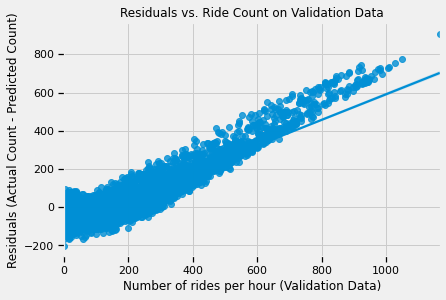

In [80]:
train = df_model_dataset[(df_model_dataset['year'] ==2018) | (df_model_dataset['year'] ==2019)]

x_no_train, y_no_train = frw_engineered_features(remove_outliers(train))


val = df_model_dataset[(df_model_dataset['year'] ==2017)]
val.reset_index(drop=True, inplace = True)

x_val, y_val = frw_engineered_features(val)



cv_scores, lt_model = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_no_train, y=y_no_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {:.2f}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {:.2f}'.format(np.std(cv_scores)))
annual_frw_avg_rmse = np.mean(cv_scores)

#test on validation data set
y_predict = lt_model.predict(x_val)

annual_frw_val_error = mean_squared_error(y_val, y_predict, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(annual_frw_val_error))
residuals = y_val -y_predict
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

# Retrain Best Performing model on current feature set

The mean absolute error for the simple Linear Regression is: 131.28


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

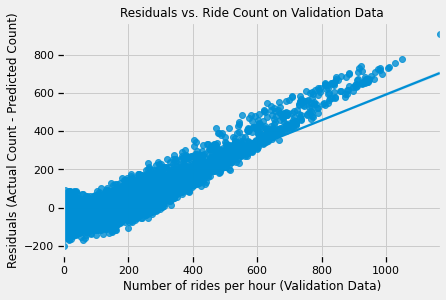

In [82]:
linear_model.fit(x_no_train,y_no_train)
best_predicted = linear_model.predict(x_val)
best_error = mean_squared_error(best_predicted, y_val, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(best_error))
residuals = y_val - best_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")

# Progression of the Linear Model

<AxesSubplot:ylabel='models'>

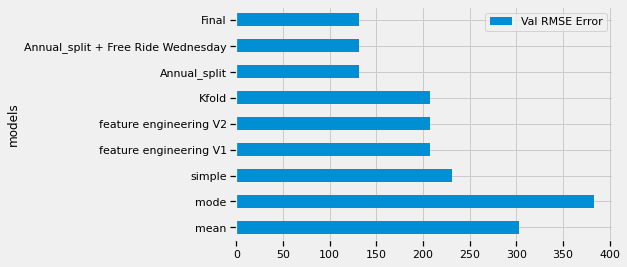

In [84]:
models = ['mean', 'mode','simple','feature engineering V1', 'feature engineering V2','Kfold','Annual_split','Annual_split + Free Ride Wednesday', 'Final']
error = [mean_error, mode_error, simple_error, fe_error, vfe_error, kfold_error, annual_val_error, annual_frw_val_error, best_error]

df_results = pd.DataFrame()
df_results['models'] = models
df_results['Val RMSE Error'] = error

df_results.set_index('models').plot(kind = 'barh')

# Run against test data set

The mean absolute error for the simple Linear Regression is: 382.07


Text(0.5, 1.0, 'Residuals vs. Ride Count on Validation Data')

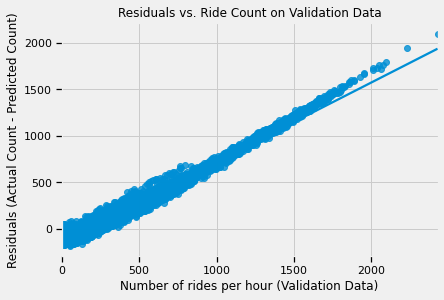

In [91]:
test = df_model_dataset[(df_model_dataset['year'] ==2020)]
test.reset_index(drop=True, inplace = True)

x_test, y_test = frw_engineered_features(test)

test_predicted = lt_model.predict(x_test)
test_error = mean_squared_error(test_predicted, y_test, squared = False)
print('The mean absolute error for the simple Linear Regression is: {:.2f}'. format(test_error))
residuals = y_test - test_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Number of rides per hour (Validation Data)')
ax.set_ylabel('Residuals (Actual Count - Predicted Count)')
ax.set_title("Residuals vs. Ride Count on Validation Data")